In [1]:
#before start run rm -rf few/.ipynb_checkpoints night/.ipynb_checkpoints overcast/.ipynb_checkpoints scattered/.ipynb_checkpoints clear/.ipynb_checkpoints
#delete brooklyn rm few/*BKLN* night/*BKLN* overcast/*BKLN* scattered/*BKLN*

In [2]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import cv2
import imghdr 
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib


In [3]:
#overcast 20191030T161529_VOOR
#partly 20191112T183029_VOOR
#clear 20190511T122529_VOOR
PATH = '/home/arnold/clouds_detection/ESSX'
data_dir = pathlib.Path(PATH)
#resize image 
# sz=224
# List containing the entries in the directory given by PATH
os.listdir(PATH)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
batch_size = 64
img_height = 720
img_width = 1080

5521


In [4]:
# folder_path = '/home/arnold/clouds_detection/ALL/clear'
# image_file_list = os.listdir(folder_path)

In [5]:
# #fix broken images
   
# for file in image_file_list:
#     file = '/home/arnold/clouds_detection/ALL/clear/'+file
# #     print(file)
#     image = cv2.imread(file)
#     file_type = imghdr.what(file)  
#     if file_type != 'jpeg':  
#         print(file +  " - invalid - " +  str(file_type))  
# #         cv2.imwrite(file, image)```

In [6]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
#list_ds
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [7]:
for f in list_ds.take(7):
  print(f.numpy())

b'/home/arnold/clouds_detection/ESSX/overcast/20151216T120501_ESSX.jpg'
b'/home/arnold/clouds_detection/ESSX/scattered/20190320T173530_VOOR.jpg'
b'/home/arnold/clouds_detection/ESSX/night/20151209T234002_ESSX.jpg'
b'/home/arnold/clouds_detection/ESSX/overcast/20170426T101519_VOOR.jpg'
b'/home/arnold/clouds_detection/ESSX/overcast/20151221T144501_ESSX.jpg'
b'/home/arnold/clouds_detection/ESSX/clear/20151209T151501_ESSX.jpg'
b'/home/arnold/clouds_detection/ESSX/overcast/20151227T193501_ESSX.jpg'


In [8]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['clear' 'night' 'overcast' 'scattered']


In [9]:
# #split into training testing and val 
# val_size = int(image_count * 0.2)
# train_ds = list_ds.skip(val_size)
# val_ds = list_ds.take(val_size)

train_size = int(image_count * 0.8)
val_size = int(image_count * 0.15)
test_size = int(image_count * 0.05)

train_ds = list_ds.take(train_size)
test_ds = list_ds.skip(train_size)
val_ds = test_ds.skip(test_size)
test_ds = test_ds.take(test_size)

In [10]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())
print(tf.data.experimental.cardinality(test_ds).numpy())

4416
829
276


In [11]:
def get_label(file_path):
  # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
    one_hot = parts[-2] == class_names
  # Integer encode the label
    return tf.argmax(one_hot)

In [12]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [13]:
def process_path(file_path):
    label = get_label(file_path)
  # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
#     img = image.img_to_array(img)
#    height, width, channels = img.shape
#    img = img[0:int(height/3), 0:width] #1/3 top 
#    img = img[0:int(height/2), 0:width] #half
    print(img.shape)
    return img, label

In [14]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)


(360, 1080, 3)
(360, 1080, 3)
(360, 1080, 3)


In [15]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (360, 1080, 3)
Label:  2


In [16]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

In [17]:
print(train_ds)

<PrefetchDataset shapes: ((None, 360, 1080, 3), (None,)), types: (tf.float32, tf.int64)>


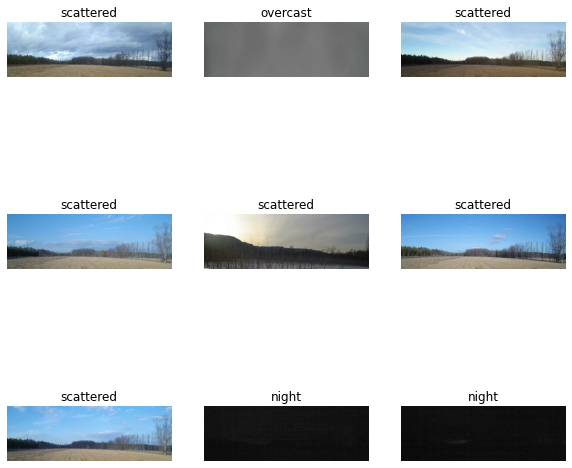

In [18]:
image_batch, label_batch = next(iter(test_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])
    plt.axis("off")

In [19]:
# plt.imshow(image_batch[8].numpy().astype("uint8"))

# img = PIL.Image.fromarray(image_batch[8].numpy().astype("uint8"))
# img.save("/home/arnold/clouds_detection/cropped")

In [20]:
#RGB channel values are in the [0, 255] range. Bad for neural network; want input values small. 
#Standardize values to be in the [0, 1] by using a Rescaling layer.
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [21]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


In [22]:
num_classes = len(class_names)
len(class_names)

4

In [23]:
# #Data augmentation - generating additional training data from your existing examples by augmenting then using random transformations that yield believable-looking images
# data_augmentation = keras.Sequential(
#   [
# #       tf.keras.layers.experimental.preprocessing.RandomCrop(
# #     240, 1280
# # )
# #     layers.experimental.preprocessing.RandomFlip("horizontal", 
# #                                                  input_shape=(img_height, 
# #                                                               img_width,
# #                                                               3)),
#     layers.experimental.preprocessing.RandomRotation(0.1),
#     layers.experimental.preprocessing.RandomZoom(0.1),
#   ]
# )

In [24]:
# # data_augmentation(image_batch)
# #viz augmented images
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#     for i in range(9):
#         augmented_images = data_augmentation(images)
#         ax = plt.subplot(3, 3, i + 1)
#         plt.title(augmented_images[0].shape)
#         plt.imshow(augmented_images[0].numpy().astype("uint8"))
#         plt.axis("off")

In [25]:
num_classes = len(class_names)
print(num_classes, img_height, img_width)

#if not doing data augmentation
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(360, 1080, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


#if doing data augmentaion
# model = Sequential([
#   data_augmentation,
#   layers.experimental.preprocessing.Rescaling(1./255),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])

4 720 1080


In [26]:
#compile the model (To view training and validation accuracy for each training epoch, pass the metrics argument)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
# model.summary()

In [28]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
69/69 [==============================] - 28s 403ms/step - loss: 1.1651 - accuracy: 0.7486 - val_loss: 0.3727 - val_accuracy: 0.8456
Epoch 2/25
69/69 [==============================] - 36s 525ms/step - loss: 0.2810 - accuracy: 0.8909 - val_loss: 0.2600 - val_accuracy: 0.8866
Epoch 3/25
69/69 [==============================] - 31s 449ms/step - loss: 0.2270 - accuracy: 0.9044 - val_loss: 0.2805 - val_accuracy: 0.8733
Epoch 4/25
69/69 [==============================] - 32s 470ms/step - loss: 0.1863 - accuracy: 0.9271 - val_loss: 0.2098 - val_accuracy: 0.9023
Epoch 5/25
69/69 [==============================] - 30s 441ms/step - loss: 0.1709 - accuracy: 0.9318 - val_loss: 0.2024 - val_accuracy: 0.9083
Epoch 6/25
69/69 [==============================] - 30s 436ms/step - loss: 0.1505 - accuracy: 0.9411 - val_loss: 0.2273 - val_accuracy: 0.9144
Epoch 7/25
69/69 [==============================] - 30s 442ms/step - loss: 0.1563 - accuracy: 0.9416 - val_loss: 0.1941 - val_accuracy: 0.9216

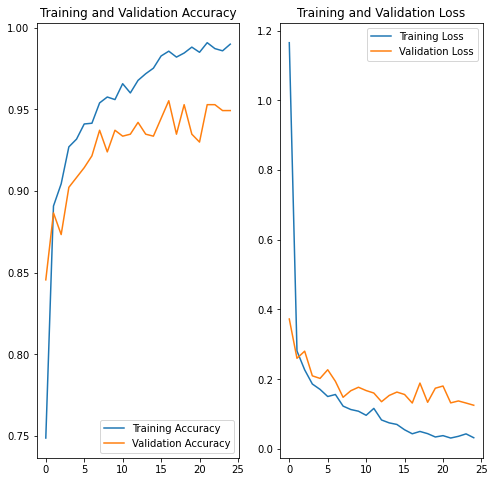

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

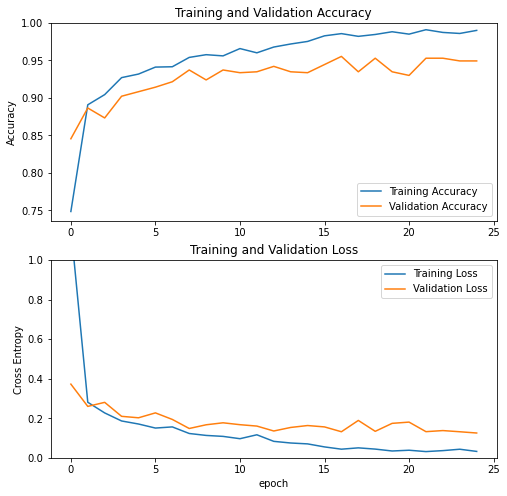

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
['clear' 'night' 'overcast' 'scattered']
[2 2 2 2 1 2 2 2 1 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 2 3 2 3 2 2 2 2 2 1 2
 2 2 1 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2
 2 1 2 3 2 2 3 2 2 2 2 2 1 2 2 2 1 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 1 2 1 2 2 2 2 3 1 2 2 2 2 1 2 2 2 2 2 2 3 2 2 2 2 1 2 2 2 2 2 2 1 2 2 3 2
 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 3 2 3 2 2 2 2 2 2 2 2 1 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 2 2 2 1 2 2 2 2 2 3 1 1 2 2 2 2 2]
This image most likely belongs to overcast with a 99.93 percent confidence.


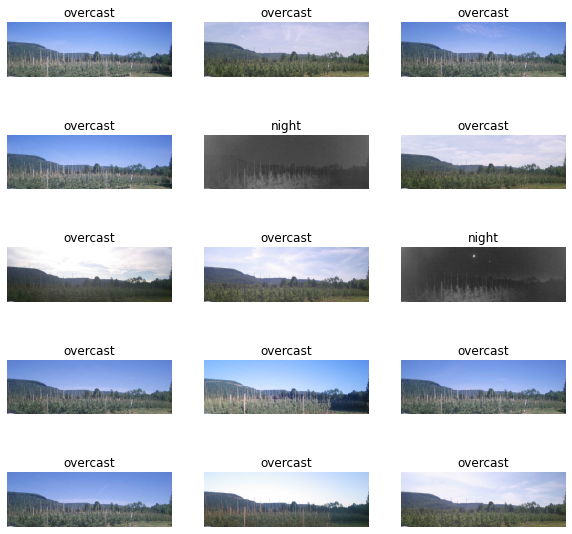

In [31]:
folder_path = '/home/mesonet/cam_photos/2018/06/17/VOOR'
from keras.preprocessing import image

# load all images into a list
paths = []
images = []
for img in os.listdir(folder_path):
    img = os.path.join(folder_path, img)
    paths.append(img)
    img = image.load_img(img, target_size=(img_height, img_width))
    img = image.img_to_array(img)
    height, width, channels = img.shape
    img = img[0:int(height/2), 0:width]
    img = np.expand_dims(img, axis=0)
    images.append(img)
# print(images[1])
# stack up images list to pass for prediction
images = np.vstack(images)
#print(paths)
# for i in paths:
#     PIL.Image.open(i)
#

classes = model.predict_classes(images, batch_size=32)
print(class_names)
print(classes)
predictions = model.predict(images)
score = tf.nn.softmax(predictions[0])
#can do softmax, sigmoid relu argmax  too
#print(predictions)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
#print(paths[-1])
#PIL.Image.open(paths[-1])
plt.figure(figsize=(10, 10))
for i in range(15):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
#     predictions = model.predict(image[i])
#     score = tf.nn.softmax(predictions[0])
#     plt.title(class_names[np.argmax(score)], 100 * np.max(score))
    plt.title(class_names[classes[i]])
    plt.axis("off")

In [32]:
# #overcast 20191030T161529_VOOR

# #rain 20161013T164513_YORK.jpg_sliding_window.jpg

# #partly 20191112T183029_VOOR

# #clear 20190511T122529_VOOR
# #clear 20191008T165026_BURT
# #clear 20160420T221001_DELE
# new_img_path = '/home/mesonet/cam_photos/2018/12/20/VOOR/20181220T175030_VOOR.jpg'
# #new_img_path = '/home/arnold/raindrop-detection-cnn/mesonet/20161013T164513_YORK.jpg_sliding_window.jpg'

# img = keras.preprocessing.image.load_img(
#     new_img_path, target_size=(img_height, img_width)
# )

# # height, width, channels = img.shape
# # print(int(height/3))
# # croppedImage = img[0:int(height/3), 0:width] #this line crops

# img_array = keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])
# print(predictions)
# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )
# PIL.Image.open(new_img_path)

In [33]:
print(val_ds.take(1))

<TakeDataset shapes: ((None, 360, 1080, 3), (None,)), types: (tf.float32, tf.int64)>


Predictions:
 [0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0
 0 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 0 1 1 0 0 1 0 0
 0 1 0 1 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0
 1 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1
 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0
 1 0 0 0 0 1 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 0
 1 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 0]
Labels:
 [1 3 2 1 3 3 2 2 1 2 0 2 3 2 1 2 3 0 3 1 2 1 1 2 3 2 1 3 1 2 2 3 2 2 1 3 0
 3 2 3 2 1 1 1 1 1 1 2 2 3 2 3 3 2 3 2 0 2 1 2 2 1 2 2]


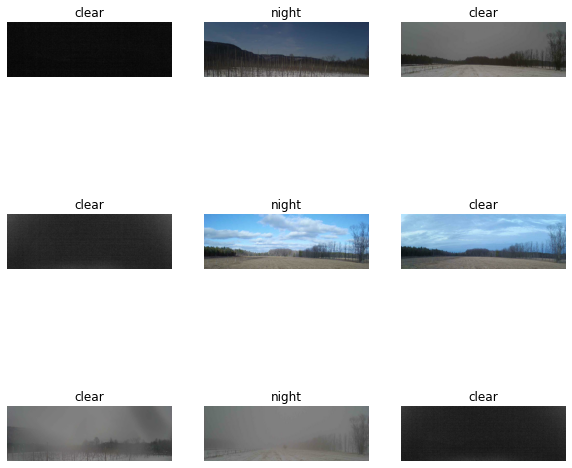

In [34]:
####Working for testing a full dataset 
#Retrieve a batch of images from the test set
#replace val_ds with test_ds
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")